# **Lab 1 - Trend Analysis**
### Submitted by Tiffany Peverilla tp2906
### Dataset used: GSS Conclerg (Confidence in Organized Religion)

### **Loading conclerg dataset**

In [ ]:
import pandas as pd
import requests
import zipfile
import io
import os
from tqdm.notebook import tqdm
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns

In [ ]:
# Step 1: Download the ZIP file with progress bar
url = 'https://gss.norc.org/content/dam/gss/get-the-data/documents/stata/GSS_stata.zip'

# Make a streaming request to get the content in chunks
response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))  # Get the total file size
block_size = 1024  # 1 Kilobyte

# Progress bar for downloading
tqdm_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
content = io.BytesIO()

# Download the file in chunks with progress bar
for data in response.iter_content(block_size):
    tqdm_bar.update(len(data))
    content.write(data)

tqdm_bar.close()

# Check if the download is successful
if total_size != 0 and tqdm_bar.n != total_size:
    print("Error in downloading the file.")
else:
    print("Download completed!")

# Step 2: Extract the ZIP file in memory and display progress
with zipfile.ZipFile(content) as z:
    # List all files in the zip
    file_list = z.namelist()

    # Filter for the .dta file (assuming there is only one)
    stata_files = [file for file in file_list if file.endswith('.dta')]

    # If there is a Stata file, proceed to extract and read it
    if stata_files:
        stata_file = stata_files[0]  # Take the first .dta file
        with z.open(stata_file) as stata_file_stream:
            # Step 3a: Load only the selected columns into a pandas DataFrame with numeric labels
            columns_to_load = ['id', 'year', 'conclerg', 'relig', 'god', 'degree', 'sex', 'age', 'class', 'health', 'partyid']
            print("Loading selected columns from Stata file with numeric labels...")
            df_numeric = pd.read_stata(stata_file_stream, columns=columns_to_load, convert_categoricals=False)
            print("Data with numeric labels loaded successfully!")

        # Reload the dataset to get categorical (string) labels
        with z.open(stata_file) as stata_file_stream:
            print("Loading selected columns from Stata file with string (categorical) labels...")
            df_categorical = pd.read_stata(stata_file_stream, columns=columns_to_load)
            print("Data with categorical labels loaded successfully!")

            # Step 3b: Rename the categorical columns by prefixing with 'z' (no period)
            df_categorical = df_categorical.rename(columns={col: f'z{col}' for col in df_categorical.columns})

# Step 4: Concatenate the numeric and categorical DataFrames side by side
df = pd.concat([df_numeric, df_categorical], axis=1)

# Step 5: Display the first few rows of the final DataFrame
df.head()

  0%|          | 0.00/45.7M [00:00<?, ?iB/s]

Download completed!
Loading selected columns from Stata file with numeric labels...
Data with numeric labels loaded successfully!
Loading selected columns from Stata file with string (categorical) labels...


/tmp/ipython-input-4197869351.py:47: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df_categorical = pd.read_stata(stata_file_stream, columns=columns_to_load)


Data with categorical labels loaded successfully!


,id,year,conclerg,relig,god,degree,sex,age,class,health,...,zyear,zconclerg,zrelig,zgod,zdegree,zsex,zage,zclass,zhealth,zpartyid
0,1,1972,NaN,3.0,NaN,3.0,2.0,23.0,3.0,2.0,...,1972,NaN,jewish,NaN,bachelor's,female,23.0,middle class,good,"independent, close to democrat"
1,2,1972,NaN,2.0,NaN,0.0,1.0,70.0,3.0,3.0,...,1972,NaN,catholic,NaN,less than high school,male,70.0,middle class,fair,not very strong democrat
2,3,1972,NaN,1.0,NaN,1.0,2.0,48.0,2.0,1.0,...,1972,NaN,protestant,NaN,high school,female,48.0,working class,excellent,"independent (neither, no response)"
3,4,1972,NaN,5.0,NaN,3.0,2.0,27.0,3.0,2.0,...,1972,NaN,other,NaN,bachelor's,female,27.0,middle class,good,not very strong democrat
4,5,1972,NaN,1.0,NaN,1.0,2.0,61.0,2.0,2.0,...,1972,NaN,protestant,NaN,high school,female,61.0,working class,good,strong democrat


### **1. Conduct a trend analysis of some variable of interest. Graph it and try different functional forms. Look for subgroup variation across time, too. Extra credit if you consider other variables as a means of explaining the trend. Explain all of your results.**


### General Confidence per Year Trend

Here, I am just interested in observing how confidence in religion has changed over time using the data we've extracted from GSS.
Since the conclerg variable is ordinal, with levels like "a great deal", "only some", and "hardly any" (pertaining to confidence in organized religion as an institution), I will create a binary variable with 1 representing "a great deal" of confidence and 0 representing all other responses.


To do this, I first clean the df and get rid of any N/A responses in 'year', 'conclerg' and 'relig' (since I want to look at relig variation later on).

/tmp/ipython-input-4071953243.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['zconclerg_binary'] = np.select(conditions, choices, default=np.nan)


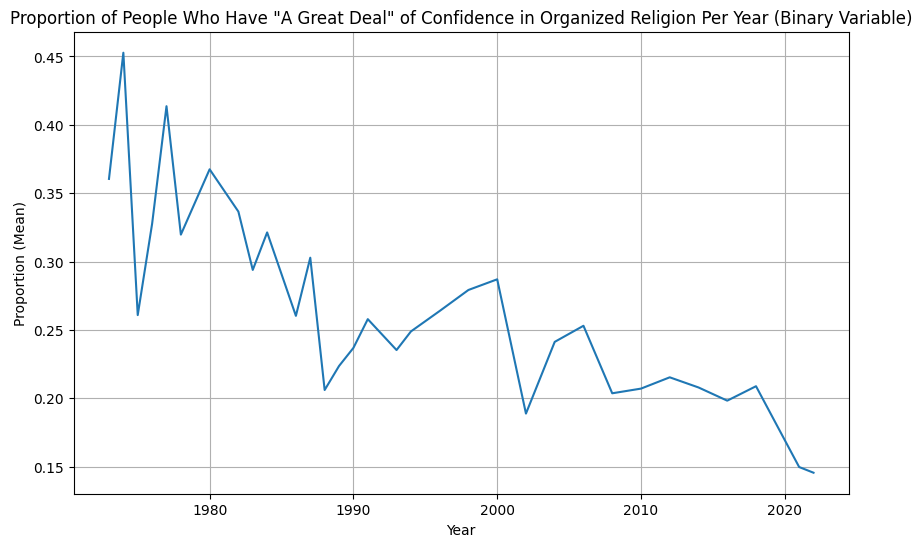

In [ ]:
# Get rid of N/A responses in 'year', 'conclerg' and 'relig
df_clean = df.dropna(subset=['year', 'conclerg', 'relig'])

# Separate conclerg into 2 – "a great deal" vs all other
conditions = [
    (df_clean['zconclerg'] == 'a great deal'), # people with a great deal of confidence in organized religion
    (df_clean['zconclerg'] != 'a great deal') # people with "only some" and "hardly any" confidence
]

choices = [1, 0] # 1 is a great deal, 0 is no/some confidence

# Creating the binary variable in df_clean
df_clean['zconclerg_binary'] = np.select(conditions, choices, default=np.nan)

# Grouping conclerg by year and determining mean of confidence
mean_conclerg_per_year = df_clean.groupby('year')['zconclerg_binary'].mean().reset_index()

# Plot year by zconclerg_binary
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='zconclerg_binary', data=mean_conclerg_per_year)
plt.title('Proportion of People Who Have "A Great Deal" of Confidence in Organized Religion Per Year (Binary Variable)')
plt.xlabel('Year')
plt.ylabel('Proportion (Mean)')
plt.grid(True)
plt.show()

From the graph above, it is clear that there is a steep decrease in confidence in organized religion from 1972 to 2024. I will now run a regression to find out the exact statistical values.

In [ ]:
# Run the regression using the formula interface
model0 = smf.ols(formula='zconclerg_binary ~ year', data=df_clean)

# Fit the model
results0 = model0.fit()

# Output the summary of the regression
print(results0.summary())

                            OLS Regression Results                            
Dep. Variable:       zconclerg_binary   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     945.2
Date:                Wed, 01 Oct 2025   Prob (F-statistic):          1.63e-205
Time:                        18:43:40   Log-Likelihood:                -27714.
No. Observations:               47133   AIC:                         5.543e+04
Df Residuals:                   47131   BIC:                         5.545e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1558      0.257     31.765      0.0

This regression shows us that the average confidence in organized religion decreases by 0.4% per year, with a very significant |t| of 30 and p-value of approximately 0. The R-squared value is also considerably impressive, with time explaining 2% of confidence in organized religion.

### Using Dummies of Year

I now want to use year dummies to look more closely into how confidence in organized religion decreases for every year listed in the data.

In [ ]:
# Step 1: Run the regression using the formula interface
model = smf.ols(formula='zconclerg_binary ~ C(year)', data=df_clean)

# Step 2: Fit the model
results = model.fit()

# Step 3: Output the summary of the regression
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       zconclerg_binary   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     42.68
Date:                Wed, 01 Oct 2025   Prob (F-statistic):          6.90e-255
Time:                        18:43:45   Log-Likelihood:                -27529.
No. Observations:               47133   AIC:                         5.512e+04
Df Residuals:                   47101   BIC:                         5.540e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3604      0.011     

With this method, we are able to show that there is quite a jump in people's confidence in organized religion around 1988 afterwards compared to the years before. The estimate coefficients before 1988 were around the range of -0.05, but after 1988 it jumped to -0.15. All of them have pretty significant |t| values as well, signifying that they are significantly different from the first year of data collection which was 1973.
The R-squared hasn't changed much, though. It stays stagnant at around 2%.

### Looking at subgroup variation (religious vs not religious) across time

For subgroup variation across time, I am interested in how religion impacts people's confidence in organized religion. It is pretty obvious that if you identify with a religion, you are more likely to have a higher confidence in organized religion. We will explore that below.

/tmp/ipython-input-942225804.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['norelig_binary'] = np.select(relig_conditions, relig_choices, default=np.nan)


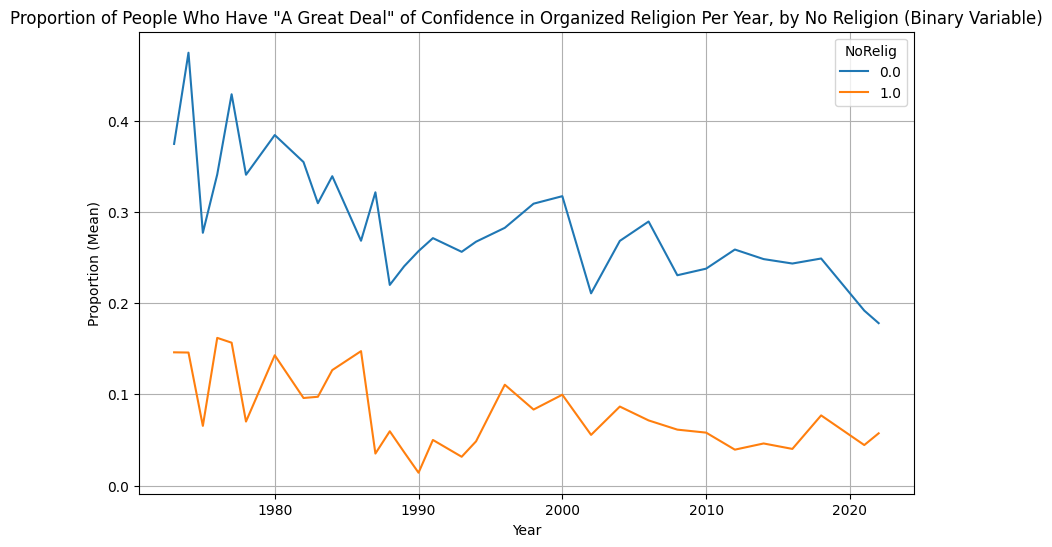

In [ ]:
# Create a binary variable for religion
relig_conditions = [
    (df_clean['relig'] == 4),  # 4 is "no religion"
    (df_clean['relig'] != 4)    # everything else is a religion
]
relig_choices = [1, 0]  # 1 if relig==4, otherwise 0
df_clean['norelig_binary'] = np.select(relig_conditions, relig_choices, default=np.nan)

# Group the data by year and the religion binary we just created
mean_conclerg_per_year_norelig = df_clean.groupby(['year', 'norelig_binary'])['zconclerg_binary'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='zconclerg_binary', hue='norelig_binary', data=mean_conclerg_per_year_norelig)
plt.title('Proportion of People Who Have "A Great Deal" of Confidence in Organized Religion Per Year, by No Religion (Binary Variable)')
plt.xlabel('Year')
plt.ylabel('Proportion (Mean)')
plt.legend(title='NoRelig')
plt.grid(True)
plt.show()

As I suspected, people who are religious (the blue line) generally have higher confidence in organized religion than people who stated themselves to have no religion (orange line).

What is perhaps more striking to me is the fact that for people who don't have religion, their confidence stays around the same range across time, while for people who are religious, their confidence experiences a decrease over time.


In [ ]:
model2 = smf.ols(formula='zconclerg_binary ~ year + norelig_binary', data=df_clean)


results2 = model2.fit()


print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:       zconclerg_binary   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     1001.
Date:                Wed, 01 Oct 2025   Prob (F-statistic):               0.00
Time:                        18:45:49   Log-Likelihood:                -27202.
No. Observations:               47133   AIC:                         5.441e+04
Df Residuals:                   47130   BIC:                         5.444e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.5137      0.259     25.

After running the regression, we see that a person with no religion is expected to have ~20% less confidence in organized religion, regardless of year. More noticeably, the R-squared has increased twofold, with religion explaining 4% of the trend in confidence in organized religion.

Now, I will look at the interaction between year and religion.

In [ ]:
model3 = smf.ols(formula='zconclerg_binary ~ year*norelig_binary', data=df_clean)

# Step 1: Fit the model
results3 = model3.fit()

# Step 2: Output the summary of the regression
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:       zconclerg_binary   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     676.8
Date:                Wed, 01 Oct 2025   Prob (F-statistic):               0.00
Time:                        18:46:47   Log-Likelihood:                -27188.
No. Observations:               47133   AIC:                         5.438e+04
Df Residuals:                   47129   BIC:                         5.442e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.0528    

From the model above, we observe that for those who are not religious, the slope of confidence is lower than those who are religious (-0.001 vs -0.0034). This is a statistically significant difference as shown by the low p-value.

### Looking at other variables: political party affiliation

I'm interested in how the seemingly unrelated variable of political party affiliation might affect confidence in organized religion.

We see below that the GSS data has 8 different variations of political party affiliation. For simplicity, I will categorize them into: democrat and republican.

In [ ]:
df_clean['zpartyid'].unique()

['other party', 'not very strong democrat', 'independent, close to republican', 'independent, close to democrat', 'strong democrat', 'independent (neither, no response)', 'strong republican', 'not very strong republican', NaN]
Categories (8, object): ['strong democrat' < 'not very strong democrat' <
                         'independent, close to democrat' < 'independent (neither, no response)' <
                         'independent, close to republican' < 'not very strong republican' < 'strong republican' <
                         'other party']

In [ ]:
# Categorizing party affiliation into democrat, republican and other
party_affil = [
    (df_clean['partyid'] <= 2), # democrat
    (df_clean['partyid'] > 3) & (df_clean['partyid'] < 7) #republican
]

party_choices = [0, 1]  # 0 if democrat, 1 if republican

df_clean['party_affil'] = np.select(party_affil, party_choices, default=np.nan)

/tmp/ipython-input-2014529584.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['party_affil'] = np.select(party_affil, party_choices, default=np.nan)


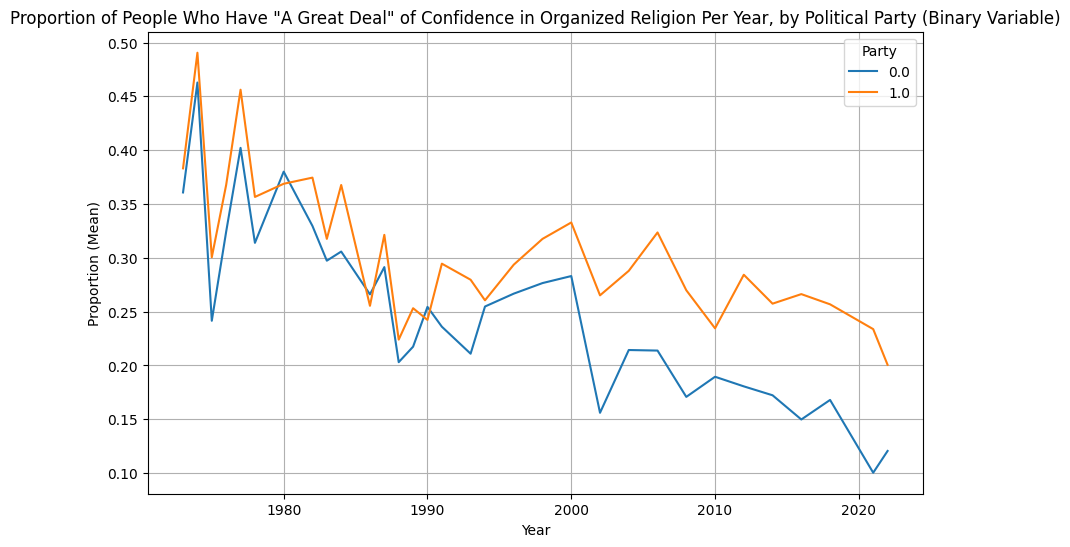

In [ ]:
# Getting rid of N/A responses
df_clean_party = df_clean.dropna(subset=['party_affil'])

# Group by year and party affiliation and calculate conclerg mean
mean_conclerg_per_year_party = df_clean_party.groupby(['year', 'party_affil'])['zconclerg_binary'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='zconclerg_binary', hue='party_affil', data=mean_conclerg_per_year_party)
plt.title('Proportion of People Who Have "A Great Deal" of Confidence in Organized Religion Per Year, by Political Party (Binary Variable)')
plt.xlabel('Year')
plt.ylabel('Proportion (Mean)')
plt.legend(title='Party')
plt.grid(True)
plt.show()

Just from looking at the graph, it looks like both political parties are in sync from 1973 to 2000 with an overlapping decreasing trend. After 2000, they diverge a little bit, with democrats scoring lower in confidence than republicans.

In [ ]:
model4 = smf.ols(formula='zconclerg_binary ~ year + party_affil', data=df_clean_party)
results4 = model4.fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:       zconclerg_binary   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     465.1
Date:                Wed, 01 Oct 2025   Prob (F-statistic):          2.39e-200
Time:                        20:29:49   Log-Likelihood:                -23342.
No. Observations:               39033   AIC:                         4.669e+04
Df Residuals:                   39030   BIC:                         4.672e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       8.5059      0.288     29.524      

My model shows that if you are a republican, you on average will have 0.05 times more confidence in organized religion than if you are a democrat. This is a statistically significant result given the high |t| and low p.

It looks like party affiliation is not as good as religion in terms of explaining the data, though, given that the R-squared value is similar to when we only used year.

In [ ]:
model5 = smf.ols(formula='zconclerg_binary ~ year*party_affil', data=df_clean_party)

results5 = model5.fit()

print(results5.summary())

                            OLS Regression Results                            
Dep. Variable:       zconclerg_binary   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     325.2
Date:                Wed, 01 Oct 2025   Prob (F-statistic):          1.48e-208
Time:                        20:29:57   Log-Likelihood:                -23320.
No. Observations:               39033   AIC:                         4.665e+04
Df Residuals:                   39029   BIC:                         4.668e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           10.0511      0.370  

Looking at the interaction between year and party affiliation, we observe that for democrats, your confidence only decreases by around 0.004 per year, whereas for republicans, your confidence decreases by 0.002 per year. Again, this is a statistically significant result but does not improve the value of R-squared.

It would be interesting to do a difference-in-difference analysis given the graph shows us a parallel trend before the year 2000, and then diverges afterwards.